# Face tracking pipeline

The following example illustrates how to use the `facenet_pytorch` python package to perform face detection and tracking on an image dataset using MTCNN.

In [1]:
!pip install facenet-pytorch

# or clone this repo, removing the '-' to allow python imports:
!git clone https://github.com/timesler/facenet-pytorch.git facenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 14.3 MB/s 
Cloning into 'facenet_pytorch'...
remote: Enumerating objects: 1267, done.
remote: Total 1267 (delta 0), reused 0 (delta 0), pack-reused 1267
Receiving objects: 100% (1267/1267), 22.88 MiB | 16.50 MiB/s, done.
Resolving deltas: 100% (619/619), done.


In [3]:
!pip install mmcv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 593 kB 9.8 MB/s 
     |████████████████████████████████| 190 kB 32.0 MB/s 
  Created wheel for mmcv: filename=mmcv-1.7.0-py2.py3-none-any.whl size=914087 sha256=518d123d4b47fbc25bb85468f46a522562931fcbf4d48376006b86022797576c
  Stored in directory: /root/.cache/pip/wheels/9b/89/2b/4dd481113713f57069c98473061037314d4f80a66077a3b5ec
Successfully built mmcv


In [4]:
from facenet_pytorch import MTCNN
import torch
import numpy as np
import mmcv
import cv2
from PIL import Image, ImageDraw
from IPython import display

/usr/local/lib/python3.8/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


#### Determine if an nvidia GPU is available

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


#### Define MTCNN module

Note that, since MTCNN is a collection of neural nets and other code, the device must be passed in the following way to enable copying of objects when needed internally.

See `help(MTCNN)` for more details.

In [6]:
mtcnn = MTCNN(keep_all=True, device=device)

#### Get a sample video

We begin by loading a video with some faces in it. The `mmcv` PyPI package by mmlabs is used to read the video frames (it can be installed with `pip install mmcv`). Frames are then converted to PIL images.

In [10]:
video = mmcv.VideoReader('facenet_pytorch/examples/video.mp4')
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]

display.Video('facenet_pytorch/examples/video.mp4', width=640)

#### Run video through MTCNN

We iterate through each frame, detect faces, and draw their bounding boxes on the video frames.

In [11]:
frames_tracked = []
for i, frame in enumerate(frames):
    print('\rTracking frame: {}'.format(i + 1), end='')
    
    # Detect faces
    boxes, _ = mtcnn.detect(frame)
    
    # Draw faces
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    for box in boxes:
        draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
    
    # Add to frame list
    frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
print('\nDone')

Tracking frame: 105
Done


#### Display detections

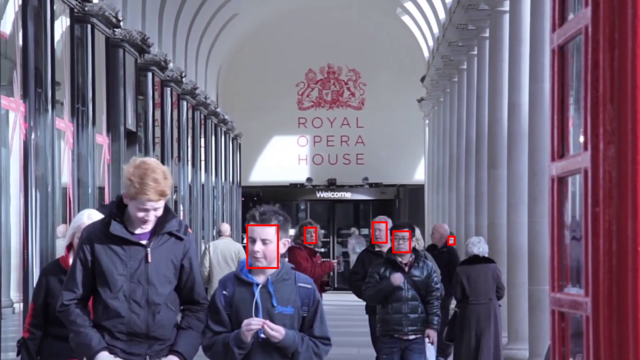

In [12]:
d = display.display(frames_tracked[0], display_id=True)
i = 1
try:
    while True:
        d.update(frames_tracked[i % len(frames_tracked)])
        i += 1
except KeyboardInterrupt:
    pass

#### Save tracked video

In [13]:
dim = frames_tracked[0].size
fourcc = cv2.VideoWriter_fourcc(*'FMP4')    
video_tracked = cv2.VideoWriter('video_tracked.mp4', fourcc, 25.0, dim)
for frame in frames_tracked:
    video_tracked.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))
video_tracked.release()